In [1]:
from __future__ import print_function
import six.moves.cPickle as pickle

from collections import OrderedDict
import sys
import time
import numpy

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu2,floatX=float32"
import theano
from theano import config
import theano.tensor as tensor
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

import imdb

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.


In [2]:
SEED = 123
numpy.random.seed(SEED)

In [3]:
def adadelta(lr, tparams, grads, x, mask, y, cost):
    """
    An adaptive learning rate optimizer

    Parameters
    ----------
    lr : Theano SharedVariable
        Initial learning rate
    tpramas: Theano SharedVariable
        Model parameters
    grads: Theano variable
        Gradients of cost w.r.t to parameres
    x: Theano variable
        Model inputs
    mask: Theano variable
        Sequence mask
    y: Theano variable
        Targets
    cost: Theano variable
        Objective fucntion to minimize

    Notes
    -----
    For more information, see [ADADELTA]_.

    .. [ADADELTA] Matthew D. Zeiler, *ADADELTA: An Adaptive Learning
       Rate Method*, arXiv:1212.5701.
    """

    zipped_grads = [theano.shared(p.get_value() * numpy_floatX(0.),
                                  name='%s_grad' % k)
                    for k, p in tparams.items()]
    running_up2 = [theano.shared(p.get_value() * numpy_floatX(0.),
                                 name='%s_rup2' % k)
                   for k, p in tparams.items()]
    running_grads2 = [theano.shared(p.get_value() * numpy_floatX(0.),
                                    name='%s_rgrad2' % k)
                      for k, p in tparams.items()]

    zgup = [(zg, g) for zg, g in zip(zipped_grads, grads)]
    rg2up = [(rg2, 0.95 * rg2 + 0.05 * (g ** 2))
             for rg2, g in zip(running_grads2, grads)]

    f_grad_shared = theano.function([x, mask, y], cost, updates=zgup + rg2up,
                                    name='adadelta_f_grad_shared')

    updir = [-tensor.sqrt(ru2 + 1e-6) / tensor.sqrt(rg2 + 1e-6) * zg
             for zg, ru2, rg2 in zip(zipped_grads,
                                     running_up2,
                                     running_grads2)]
    ru2up = [(ru2, 0.95 * ru2 + 0.05 * (ud ** 2))
             for ru2, ud in zip(running_up2, updir)]
    param_up = [(p, p + ud) for p, ud in zip(tparams.values(), updir)]

    f_update = theano.function([lr], [], updates=ru2up + param_up,
                               on_unused_input='ignore',
                               name='adadelta_f_update')

    return f_grad_shared, f_update

In [4]:
# the same as model_options = locals().copy() in function train_lstm
model_options = {}
model_options.update({'test_size': 500, 'reload_model': None, 'use_dropout': True,
                       'noise_std': 0.0, 'dataset': 'imdb', 'valid_batch_size': 64,
                       'batch_size': 16, 'maxlen': 100, 'saveFreq': 1110, 'validFreq': 370,
                       'saveto': 'lstm_model.npz', 'encoder': 'vanilla', 'optimizer': adadelta,
                       'n_words': 10000, 'lrate': 0.0001, 'decay_c': 0.0, 
                       'dispFreq': 10, 'max_epochs': 100, 'patience': 10, 'dim_proj': 128})
# 7078735  total words  114053  unique words

In [5]:
print(model_options)

{'test_size': 500, 'reload_model': None, 'use_dropout': True, 'noise_std': 0.0, 'dataset': 'imdb', 'valid_batch_size': 64, 'batch_size': 16, 'maxlen': 100, 'saveFreq': 1110, 'validFreq': 370, 'saveto': 'lstm_model.npz', 'encoder': 'vanilla', 'optimizer': <function adadelta at 0x1079f1ea0>, 'n_words': 10000, 'lrate': 0.0001, 'decay_c': 0.0, 'dispFreq': 10, 'max_epochs': 100, 'patience': 10, 'dim_proj': 128}


In [6]:
datasets = {'imdb': (imdb.load_data, imdb.prepare_data)}
def get_dataset(name):
    return datasets[name][0], datasets[name][1]

In [7]:
# Get the function names from imdb module
load_data, prepare_data = get_dataset(model_options['dataset'])

In [8]:
# imdb.load_data(n_words, valid_portion, maxlen)
print('Loading data')
n_words = model_options['n_words'] # Vocabulary size
maxlen = model_options['maxlen'] # Sequence longer then this get ignored
train, valid, test = load_data(n_words=n_words, valid_portion=0.05,
                                   maxlen=maxlen)

Loading data


In [9]:
# check from imdb.load_data function that train includes train_x, train_y
# print some train_x and train_y to get the sense what they look like
train_x, train_y = train

print(train_x[0:3])
print(train_y[0:3])
print(len(train_x))

[[16, 586, 32, 885, 17, 39, 68, 31, 2994, 2389, 328, 4], [1, 2, 1, 139, 6, 130, 1, 5, 6, 25, 105, 4730, 40], [30, 287, 142, 2216, 707, 3763, 20, 68, 57, 30, 37, 309, 14, 4]]
[0, 0, 0]
1998


In [10]:
test_size = model_options['test_size']
print(test_size)

# Select randomly the test_size number of test smaples from test which is much largerb
# The test set is sorted by size, but we want to keep random
# size example.  So we must select a random selection of the
# examples.
if test_size > 0:
    print(len(test[0]))
    idx = numpy.arange(len(test[0])) # test[0] is test_x
    numpy.random.shuffle(idx) # shuffle: to rearrange (playing cards, dominoes, tiles, etc.) to produce a random order
    idx = idx[:test_size]
    test = ([test[0][n] for n in idx], [test[1][n] for n in idx])

500
25000


In [11]:
# Get the number of sentimental class
ydim = numpy.max(train[1]) + 1 # train_y = train[1]
model_options['ydim'] = ydim

In [12]:
def ortho_weight(ndim):
    W = numpy.random.randn(ndim, ndim)
    u, s, v = numpy.linalg.svd(W)
    return u.astype(config.floatX)

In [13]:
def _p(pp, name):
    return '%s_%s' % (pp, name)

In [14]:
# Initialize the parameters of lstm layer
def param_init_lstm(options, params, prefix='lstm'):
    """
    Init the LSTM parameter:

    :see: init_params
    """
    W = numpy.concatenate([ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj'])], axis=1)
    params[_p(prefix, 'W')] = W # _p is a function to concate prefix and W --> lstm_W
    U = numpy.concatenate([ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj'])], axis=1)
    params[_p(prefix, 'U')] = U
    b = numpy.zeros((4 * options['dim_proj'],))
    params[_p(prefix, 'b')] = b.astype(config.floatX)

    return params

In [15]:
params_test = OrderedDict()
def ptest(options, params_test, prefix='lstm'):
    W = numpy.concatenate([ortho_weight(2),
                       ortho_weight(2),
                       ortho_weight(2),
                       ortho_weight(2)], axis=1)
    params_test[_p('lstm', 'W')] = W # what _p here mean???
    return params_test

ptest(model_options, params_test, prefix=model_options['encoder'])

OrderedDict([('lstm_W',
              array([[-0.17359549, -0.98481703, -0.77882504, -0.62724125, -0.96111071,
                       0.27616337, -0.59999859, -0.80000103],
                     [-0.98481703,  0.17359549, -0.62724125,  0.77882504,  0.27616337,
                       0.96111071, -0.80000103,  0.59999859]], dtype=float32))])

In [16]:
# state_below is passed in the emb --> the weights in the first layer ? why not X
# because emb is the embedding of words which represents words
def lstm_layer(tparams, state_below, options, prefix='lstm', mask=None):
    nsteps = state_below.shape[0] # time steps namely, the number of words in a sentence
    if state_below.ndim == 3:
        n_samples = state_below.shape[1] # the number of sentences in a minibatch
    else:
        n_samples = 1 # in the case of no minibach applied, then train with one sentence at a time

    assert mask is not None # sequence mask must be provided

    def _slice(_x, n, dim):
        if _x.ndim == 3:
            return _x[:, :, n * dim:(n + 1) * dim]
        return _x[:, n * dim:(n + 1) * dim]

    # m_: mask, x_: state_below which is emb * lstm_W + lstm_b
    def _step(m_, x_, h_, c_):
        preact = tensor.dot(h_, tparams[_p(prefix, 'U')]) # lstm_U*h_t-1
        preact += x_ # Wemb * lstm_W + lstm_b + lstm_U*h_t-1

        i = tensor.nnet.sigmoid(_slice(preact, 0, options['dim_proj']))
        f = tensor.nnet.sigmoid(_slice(preact, 1, options['dim_proj']))
        o = tensor.nnet.sigmoid(_slice(preact, 2, options['dim_proj']))
        c = tensor.tanh(_slice(preact, 3, options['dim_proj']))

        c = f * c_ + i * c # c_ means previous state refer to s[t]= f*s[t-1] + i*s[t]
        c = m_[:, None] * c + (1. - m_)[:, None] * c_ # c is of shape (minibatch maxlen, number of sentences
                                                    # in a minibatch, word embbdeding size) = (98, 16, 4)
        # c = theano.printing.Print('c')(c)

        h = o * tensor.tanh(c)
        h = m_[:, None] * h + (1. - m_)[:, None] * h_ # ??

        return h, c

    # emb * lstm_W + lstm_b
    state_below = (tensor.dot(state_below, tparams[_p(prefix, 'W')]) +
                   tparams[_p(prefix, 'b')])

    dim_proj = options['dim_proj']
    # scan function, sequence is the input x, nonsequence is ussually not iterated such as w and b
    rval, updates = theano.scan(_step,
                                sequences=[mask, state_below],
                                outputs_info=[tensor.alloc(numpy_floatX(0.),
                                                           n_samples,
                                                           dim_proj),
                                              tensor.alloc(numpy_floatX(0.),
                                                           n_samples,
                                                           dim_proj)],
                                name=_p(prefix, '_layers'),
                                n_steps=nsteps) # repeat as the number of words in a sentence
    return rval[0] # rval = h which is of shape (n_samples, dim_proj)

In [17]:
def gru_layer(tparams, state_below, options, prefix='gru', mask=None):
    nsteps = state_below.shape[0]
    if state_below.ndim == 3:
        n_samples = state_below.shape[1]
    else:
        n_samples = 1

    assert mask is not None

    def _slice(_x, n, dim):
        if _x.ndim == 3:
            return _x[:, :, n * dim:(n + 1) * dim]
        return _x[:, n * dim:(n + 1) * dim]
    
    def x_seperate(_x, dim):
        if _x.ndim == 3:
            return _x[:, :, 0: 2 * dim], _x[:, :, 2 * dim:]
        return _x[:, 0: 2 * dim], _x[:, 2 * dim:]

    def _step(m_, x_, h_):
        _x12, _x3 = x_seperate(x_, model_options['dim_proj'])

        preact = tensor.dot(h_, tparams[_p(prefix, 'U')])
        preact += _x12

        m = tensor.nnet.sigmoid(preact)
        r = _slice(m, 0, model_options['dim_proj'])
        u = _slice(m, 1, model_options['dim_proj'])

        _h = tensor.tanh(_x3 + tensor.dot(r * h_, tparams[_p(prefix, 'W_hh')]))
        h = u * h_ + (1.0 - u) * _h

        h = m_[:, None] * h + (1. - m_)[:, None] * h_

        return h

    state_below = (tensor.dot(state_below, tparams[_p(prefix, 'W')]) +
                   tparams[_p(prefix, 'b')])

    dim_proj = options['dim_proj']
    initial_hidden_vector = tensor.alloc(numpy_floatX(0.), n_samples, dim_proj)

    rval, updates = theano.scan(_step,
                                sequences=[mask, state_below],
                                outputs_info=[initial_hidden_vector],
                                name=_p(prefix, '_layers'),
                                n_steps=nsteps)
    return rval[0]

In [18]:
# Initialize the parameters of gru layer
def param_init_gru(options, params, prefix='gru'):
    """
    Init the GRU parameter:

    :see: init_params
    """
    W = numpy.concatenate([ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj'])], axis=1)
    params[_p(prefix, 'W')] = W
        
    U = numpy.concatenate([ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj'])], axis=1)
    params[_p(prefix, 'U')] = U

    W_hh = ortho_weight(options['dim_proj'])
    params[_p(prefix, 'W_hh')] = W_hh

    b = numpy.zeros((3 * options['dim_proj'],))
    params[_p(prefix, 'b')] = b.astype(config.floatX)

    return params

In [19]:
def vanilla_layer(tparams, state_below, options, prefix='vanilla', mask=None):
    nsteps = state_below.shape[0]
    if state_below.ndim == 3:
        n_samples = state_below.shape[1]
    else:
        n_samples = 1

    assert mask is not None

    def _step(m_, x_, h_):
        a = x_ + tensor.dot(h_, tparams[_p(prefix, 'W')])
        h = tensor.tanh(a)
        h = m_[:, None] * h + (1. - m_)[:, None] * h_
        return h

    state_below = (tensor.dot(state_below, tparams[_p(prefix, 'U')]) +
                   tparams[_p(prefix, 'b')])

    dim_proj = options['dim_proj']
    initial_hidden_vector = tensor.alloc(numpy_floatX(0.), n_samples, dim_proj)

    rval, updates = theano.scan(_step,
                                sequences=[mask, state_below],
                                outputs_info=[initial_hidden_vector],
                                name=_p(prefix, '_layers'),
                                n_steps=nsteps)
    return rval[0]

In [20]:
def param_init_vanilla(options, params, prefix='vanilla'):
    """
    Init the vanilla RNN parameter:

    :see: init_params
    """
    ndim = options['dim_proj']
    W_bound = numpy.sqrt(6. / (ndim + ndim))

    U = numpy.asarray(numpy.random.uniform(low=-W_bound, high=W_bound, size=(ndim, ndim)))
    params[_p(prefix, 'U')] = U.astype(config.floatX)
    
    W = numpy.asarray(numpy.random.uniform(low=-W_bound, high=W_bound, size=(ndim, ndim)))
    params[_p(prefix, 'W')] = W.astype(config.floatX)

    b = numpy.zeros(options['dim_proj'],)
    params[_p(prefix, 'b')] = b.astype(config.floatX)

    return params

In [21]:
# ff: Feed Forward (normal neural net), only useful to put after lstm
#     before the classifier.
layers = {'lstm': (param_init_lstm, lstm_layer), \
         'gru': (param_init_gru, gru_layer), \
         'vanilla': (param_init_vanilla, vanilla_layer)}

def get_layer(name):
    fns = layers[name]
    return fns

In [22]:
def init_params(options):
    """
    Global (not LSTM) parameters. For the embeding and the classifier.
    """
    params = OrderedDict()

    # embedding layer
    randn = numpy.random.rand(options['n_words'],
                              options['dim_proj']) # n_words = vocabulary size, dim_proj = word embedding size
    
    params['Wemb'] = (0.01 * randn).astype(config.floatX)

    # lstm layer
    params = get_layer(options['encoder'])[0](options, params, prefix=options['encoder'])

    # classifier
    params['U'] = 0.01 * numpy.random.randn(options['dim_proj'],
                                            options['ydim']).astype(config.floatX)
    params['b'] = numpy.zeros((options['ydim'],)).astype(config.floatX)

    return params

In [23]:
params = init_params(model_options)

In [24]:
def init_tparams(params):
    tparams = OrderedDict()
    for kk, pp in params.items():
        tparams[kk] = theano.shared(params[kk], name=kk)
    return tparams

In [25]:
# This create Theano Shared Variable from the parameters.
# Dict name (string) -> Theano Tensor Shared Variable
# params and tparams have different copy of the weights. --> dont know why use different copies
tparams = init_tparams(params)

In [26]:
emb = tparams['Wemb']
print(emb.shape.eval())

[10000   128]


In [27]:
# state_before is proj namely hidden state
def dropout_layer(state_before, use_noise, trng):
    proj = tensor.switch(use_noise,
                         (state_before *
                          trng.binomial(state_before.shape,
                                        p=0.5, n=1,
                                        dtype=state_before.dtype)),
                         state_before * 0.5)
    return proj

In [28]:
def numpy_floatX(data):
    return numpy.asarray(data, dtype=config.floatX)

In [29]:
def build_model(tparams, options):
    trng = RandomStreams(SEED)

    # Used for dropout.
    use_noise = theano.shared(numpy_floatX(0.)) # --> [0], thus this line of code is the same as use_noise=[0]

    x = tensor.matrix('x', dtype='int64') # x is a sentence with each word form a row?
    mask = tensor.matrix('mask', dtype=config.floatX) # sequence mask
    y = tensor.vector('y', dtype='int64')

    n_timesteps = x.shape[0] # number of words per sentence
    n_samples = x.shape[1] # number of sentences in a minibatch

    # x.flatten() --> number of words * word embeded
    emb = tparams['Wemb'][x.flatten()].reshape([n_timesteps,
                                                n_samples,
                                                options['dim_proj']]) # each word in the sentence
                                                                      # get different weights

    # call get_layer(options['encoder'])[1] --> lstm_layer --> lstm_layer(tparams,...,)
    # here emb is used to initialize states_below in lstm_layer function
    proj = get_layer(options['encoder'])[1](tparams, emb, options,
                                            prefix=options['encoder'],
                                            mask=mask)

    projshape = theano.printing.Print('proj')(proj.shape)
    # mean over word hidden representations in a sentence, proj is of shape(n_samples, dim_proj)
    if options['encoder'] == 'lstm' or options['encoder'] == 'gru':
        proj = (proj * mask[:, :, None]).sum(axis=0) # add up the hidden representations of all words in a sentence
        proj = proj / mask.sum(axis=0)[:, None] # mask.sum(axis=0) is the length of sentence without padding
    if options['use_dropout']:
        proj = dropout_layer(proj, use_noise, trng)

    # last layer
    pred = tensor.nnet.softmax(tensor.dot(proj, tparams['U']) + tparams['b'])
    # pred is the probability of a sentence belonging to a class. It is of shape (n_samples, class)

    f_pred_prob = theano.function([x, mask], pred, name='f_pred_prob')
    f_pred = theano.function([x, mask], pred.argmax(axis=1), name='f_pred')

    off = 1e-8
    if pred.dtype == 'float16':
        off = 1e-6

    # get the probability of the right class and calculate its negative log. --> negative log likelihood
    cost = -tensor.log(pred[tensor.arange(n_samples), y] + off).mean()

    return use_noise, x, mask, y, f_pred_prob, f_pred, cost

In [30]:
# What this step do?
(use_noise, x, mask,
 y, f_pred_prob, f_pred, cost) = build_model(tparams, model_options)

In [31]:
# add weight decay
decay_c = model_options['decay_c']
if decay_c > 0.:
    decay_c = theano.shared(numpy_floatX(decay_c), name='decay_c')
    weight_decay = 0.
    weight_decay += (tparams['U'] ** 2).sum()
    weight_decay *= decay_c
    cost += weight_decay

In [32]:
# define cost that includes weight decay
f_cost = theano.function([x, mask, y], cost, name='f_cost')

In [33]:
# define gradient functions
grads = tensor.grad(cost, wrt=list(tparams.values()))
f_grad = theano.function([x, mask, y], grads, name='f_grad')

In [34]:
# define optmizer
optimizer = model_options['optimizer']
lr = tensor.scalar(name='lr')
f_grad_shared, f_update = optimizer(lr, tparams, grads,
                                        x, mask, y, cost)

In [35]:
def get_minibatches_idx(n, minibatch_size, shuffle=False):
    """
    Used to shuffle the dataset at each iteration.
    """

    idx_list = numpy.arange(n, dtype="int32")

    if shuffle:
        numpy.random.shuffle(idx_list)

    minibatches = []
    minibatch_start = 0
    for i in range(n // minibatch_size):
        minibatches.append(idx_list[minibatch_start:
                                    minibatch_start + minibatch_size])
        minibatch_start += minibatch_size

    if (minibatch_start != n):
        # Make a minibatch out of what is left
        minibatches.append(idx_list[minibatch_start:])

    return zip(range(len(minibatches)), minibatches)

In [36]:
print('Optimization')
valid_batch_size = model_options['valid_batch_size']
kf_valid = get_minibatches_idx(len(valid[0]), valid_batch_size)
kf_test = get_minibatches_idx(len(test[0]), valid_batch_size)

Optimization


In [37]:
print("%d train examples" % len(train[0]))
print("%d valid examples" % len(valid[0]))
print("%d test examples" % len(test[0]))

1998 train examples
105 valid examples
500 test examples


In [38]:
history_errs = []
best_p = None # for storing best parameters
bad_count = 0

In [39]:
# Compute the validation error after this number of update.
validFreq = model_options['validFreq']

# The batch size during training.
batch_size = model_options['batch_size']

saveFreq = model_options['saveFreq']

if validFreq == -1:
    validFreq = len(train[0]) // batch_size
if saveFreq == -1:
    saveFreq = len(train[0]) // batch_size

In [40]:
uidx = 0  # the number of update done
estop = False  # early stop

In [41]:
def unzip(zipped):
    """
    When we pickle the model. Needed for the GPU stuff.
    """
    new_params = OrderedDict()
    for kk, vv in zipped.items():
        new_params[kk] = vv.get_value()
    return new_params

In [42]:
def zipp(params, tparams):
    """
    When we reload the model. Needed for the GPU stuff.
    """
    for kk, vv in params.items():
        tparams[kk].set_value(vv)

In [43]:
def pred_error(f_pred, prepare_data, data, iterator, verbose=False):
    """
    Just compute the error
    f_pred: Theano fct computing the prediction
    prepare_data: usual prepare_data for that dataset.
    """
    valid_err = 0
    for _, valid_index in iterator:
        x, mask, y = prepare_data([data[0][t] for t in valid_index],
                                  numpy.array(data[1])[valid_index],
                                  maxlen=None)
        preds = f_pred(x, mask)
        targets = numpy.array(data[1])[valid_index]
        valid_err += (preds == targets).sum()
    valid_err = 1. - numpy_floatX(valid_err) / len(data[0])

    return valid_err

In [44]:
max_epochs = model_options['max_epochs']
dispFreq = model_options['dispFreq'] # Display to stdout the training progress every N updates
saveFreq = model_options['saveFreq']
saveto = model_options['saveto'] # The best model will be saved there

lrate = model_options['lrate']
patience = model_options['patience']

train_costs = numpy.array([]) # add for plot
train_accus = numpy.array([])

start_time = time.time()
try:
    for eidx in range(max_epochs):
        n_samples = 0 # the number of sentence

        # Get new shuffled index for the training set.
        kf = get_minibatches_idx(len(train[0]), batch_size, shuffle=True)

        for _, train_index in kf:
            uidx += 1
            use_noise.set_value(1.) # going to use noise

            # Select the random examples for this minibatch
            y = [train[1][t] for t in train_index]
            x = [train[0][t] for t in train_index] # wrap 16 sentences into an array 
                                        # as a result, x is of 2 dimensions, size of 1998/16 * 16 sentences
            # Get the data in numpy.ndarray format
            # This swap the axis!
            # Return something of shape (minibatch maxlen, n samples)
            # n_samples is the number of sentences in a minibatch
            x, mask, y = prepare_data(x, y) # all the sentence will have the same length which is minibatch maxlen
            n_samples += x.shape[1] # x.shape[1] is the number of sentence in a minibatch

            cost = f_grad_shared(x, mask, y) # call the model
            f_update(lrate)

            accuracy = (f_pred(x, mask) == y).sum() / len(y)
            train_costs = numpy.append(train_costs, cost)
            train_accus = numpy.append(train_accus, accuracy)

            if numpy.isnan(cost) or numpy.isinf(cost):
                print('bad cost detected: ', cost)
                break
            if numpy.mod(uidx, dispFreq) == 0:
                print('Epoch ', eidx, 'Update ', uidx, 'Cost ', cost)
            if saveto and numpy.mod(uidx, saveFreq) == 0:
                print('Saving...')

                if best_p is not None:
                    params = best_p
                else:
                    params = unzip(tparams)
                    numpy.savez(saveto, history_errs=history_errs, **params)
                    pickle.dump(model_options, open('%s.pkl' % saveto, 'wb'), -1)
                    print('Done')
            if numpy.mod(uidx, validFreq) == 0:
                use_noise.set_value(0.) # at validation stage, dont use noise
                train_err = pred_error(f_pred, prepare_data, train, kf)
                valid_err = pred_error(f_pred, prepare_data, valid, kf_valid)
                test_err = pred_error(f_pred, prepare_data, test, kf_test)
                
                kf_valid = get_minibatches_idx(len(valid[0]), valid_batch_size)
                kf_test = get_minibatches_idx(len(test[0]), valid_batch_size)

                history_errs.append([valid_err, test_err])

                if (best_p is None or
                    valid_err <= numpy.array(history_errs)[:, 0].min()):

                    best_p = unzip(tparams)
                    bad_counter = 0

                print('Train ', train_err, 'Valid ', valid_err,
                       'Test ', test_err)

                if (len(history_errs) > patience and
                    valid_err >= numpy.array(history_errs)[:-patience,
                                                           0].min()):
                    bad_counter += 1
                    if bad_counter > patience:
                        print('Early Stop!')
                        estop = True
                        break

        print('Seen %d samples' % n_samples)

        if estop:
            break

except KeyboardInterrupt:
    print("Training interupted")

end_time = time.time()

if best_p is not None:
    zipp(best_p, tparams)
else:
    best_p = unzip(tparams)

use_noise.set_value(0.)
kf_train_sorted = get_minibatches_idx(len(train[0]), batch_size)
train_err = pred_error(f_pred, prepare_data, train, kf_train_sorted)
valid_err = pred_error(f_pred, prepare_data, valid, kf_valid)
test_err = pred_error(f_pred, prepare_data, test, kf_test)

print( 'Train ', train_err, 'Valid ', valid_err, 'Test ', test_err )
if saveto:
    numpy.savez(saveto, train_err=train_err,
                valid_err=valid_err, test_err=test_err,
                history_errs=history_errs, **best_p)
print('The code run for %d epochs, with %f sec/epochs' % (
    (eidx + 1), (end_time - start_time) / (1. * (eidx + 1))))
print( ('Training took %.1fs' %
        (end_time - start_time)), file=sys.stderr)

Epoch  0 Update  10 Cost  0.6891032457351685
Epoch  0 Update  20 Cost  0.6964811086654663
Epoch  0 Update  30 Cost  0.6890573501586914
Epoch  0 Update  40 Cost  0.6765437126159668
Epoch  0 Update  50 Cost  0.6763470768928528
Epoch  0 Update  60 Cost  0.6866199970245361
Epoch  0 Update  70 Cost  0.685305118560791
Epoch  0 Update  80 Cost  0.6958016157150269
Epoch  0 Update  90 Cost  0.6191020607948303
Epoch  0 Update  100 Cost  0.6703450679779053
Epoch  0 Update  110 Cost  0.7840390205383301
Epoch  0 Update  120 Cost  0.6515365839004517
Seen 1998 samples
Epoch  1 Update  130 Cost  0.653624951839447
Epoch  1 Update  140 Cost  0.6575479507446289
Epoch  1 Update  150 Cost  0.7022350430488586
Epoch  1 Update  160 Cost  0.7055808901786804
Epoch  1 Update  170 Cost  0.7376614809036255
Epoch  1 Update  180 Cost  0.657426655292511
Epoch  1 Update  190 Cost  0.6645267009735107
Epoch  1 Update  200 Cost  0.6830052733421326
Epoch  1 Update  210 Cost  0.676314651966095
Epoch  1 Update  220 Cost  0.

Epoch  13 Update  1680 Cost  0.6207460165023804
Epoch  13 Update  1690 Cost  0.3426074981689453
Epoch  13 Update  1700 Cost  0.7367215156555176
Epoch  13 Update  1710 Cost  0.6893990635871887
Epoch  13 Update  1720 Cost  0.6466503143310547
Epoch  13 Update  1730 Cost  0.9217573404312134
Seen 1998 samples
Epoch  14 Update  1740 Cost  0.5579392313957214
Epoch  14 Update  1750 Cost  0.5407689809799194
Epoch  14 Update  1760 Cost  0.5653913617134094
Epoch  14 Update  1770 Cost  0.6037696599960327
Epoch  14 Update  1780 Cost  0.5459418892860413
Epoch  14 Update  1790 Cost  0.6155243515968323
Epoch  14 Update  1800 Cost  0.49700480699539185
Epoch  14 Update  1810 Cost  0.5885031819343567
Epoch  14 Update  1820 Cost  0.6746240854263306
Epoch  14 Update  1830 Cost  0.4112990200519562
Epoch  14 Update  1840 Cost  0.8197866678237915
Epoch  14 Update  1850 Cost  0.41489505767822266
Train  0.974974974975 Valid  0.419047619048 Test  0.494
Seen 1920 samples
Epoch  15 Update  1860 Cost  0.57342833280

Epoch  26 Update  3290 Cost  0.4229514002799988
Epoch  26 Update  3300 Cost  0.5474579930305481
Epoch  26 Update  3310 Cost  0.5067527890205383
Epoch  26 Update  3320 Cost  0.4572712481021881
Epoch  26 Update  3330 Cost  0.633399486541748
Saving...
Train  0.970970970971 Valid  0.390476190476 Test  0.512
Seen 1920 samples
Epoch  27 Update  3340 Cost  0.5165529251098633
Epoch  27 Update  3350 Cost  0.5407524704933167
Epoch  27 Update  3360 Cost  0.6017470359802246
Epoch  27 Update  3370 Cost  0.7510111331939697
Epoch  27 Update  3380 Cost  0.5695583820343018
Epoch  27 Update  3390 Cost  0.46876657009124756
Epoch  27 Update  3400 Cost  0.5322052240371704
Epoch  27 Update  3410 Cost  0.4851595163345337
Epoch  27 Update  3420 Cost  0.6191631555557251
Epoch  27 Update  3430 Cost  0.8003675937652588
Epoch  27 Update  3440 Cost  0.5864619016647339
Epoch  27 Update  3450 Cost  0.7812020778656006
Seen 1998 samples
Epoch  28 Update  3460 Cost  0.5064061880111694
Epoch  28 Update  3470 Cost  0.623

Epoch  39 Update  4890 Cost  0.3761168420314789
Epoch  39 Update  4900 Cost  0.3803054094314575
Epoch  39 Update  4910 Cost  0.6685000061988831
Epoch  39 Update  4920 Cost  0.5288018584251404
Epoch  39 Update  4930 Cost  0.4319306015968323
Seen 1998 samples
Epoch  40 Update  4940 Cost  0.45189112424850464
Epoch  40 Update  4950 Cost  0.4376416802406311
Epoch  40 Update  4960 Cost  0.5116108059883118
Epoch  40 Update  4970 Cost  0.47086116671562195
Epoch  40 Update  4980 Cost  0.4659583270549774
Epoch  40 Update  4990 Cost  0.6128785014152527
Epoch  40 Update  5000 Cost  0.5808008909225464
Epoch  40 Update  5010 Cost  0.47178322076797485
Epoch  40 Update  5020 Cost  0.6018107533454895
Epoch  40 Update  5030 Cost  0.6476927399635315
Epoch  40 Update  5040 Cost  0.5366712212562561
Epoch  40 Update  5050 Cost  0.4273204505443573
Epoch  40 Update  5060 Cost  0.5170904397964478
Seen 1998 samples
Epoch  41 Update  5070 Cost  0.6873651146888733
Epoch  41 Update  5080 Cost  0.5081242322921753
E

Epoch  52 Update  6500 Cost  0.6383134722709656
Epoch  52 Update  6510 Cost  0.729727566242218
Epoch  52 Update  6520 Cost  0.4830766022205353
Epoch  52 Update  6530 Cost  0.6337043046951294
Epoch  52 Update  6540 Cost  0.5337130427360535
Seen 1998 samples
Epoch  53 Update  6550 Cost  0.7005707621574402
Epoch  53 Update  6560 Cost  0.4914426803588867
Epoch  53 Update  6570 Cost  0.6603774428367615
Epoch  53 Update  6580 Cost  0.5999717116355896
Epoch  53 Update  6590 Cost  0.5440765023231506
Epoch  53 Update  6600 Cost  0.9056997895240784
Epoch  53 Update  6610 Cost  0.6818557977676392
Epoch  53 Update  6620 Cost  0.49176427721977234
Epoch  53 Update  6630 Cost  0.5127447247505188
Epoch  53 Update  6640 Cost  0.3821422755718231
Epoch  53 Update  6650 Cost  0.5039528608322144
Epoch  53 Update  6660 Cost  0.521681547164917
Saving...
Train  0.971471471471 Valid  0.409523809524 Test  0.516
Seen 1920 samples
Epoch  54 Update  6670 Cost  0.6031944751739502
Epoch  54 Update  6680 Cost  0.7615

Epoch  65 Update  8110 Cost  0.5789375901222229
Epoch  65 Update  8120 Cost  0.5068097114562988
Epoch  65 Update  8130 Cost  0.6230202317237854
Epoch  65 Update  8140 Cost  0.5001761317253113
Train  0.975475475475 Valid  0.409523809524 Test  0.516
Seen 1920 samples
Epoch  66 Update  8150 Cost  0.6343976259231567
Epoch  66 Update  8160 Cost  0.6084450483322144
Epoch  66 Update  8170 Cost  0.49743202328681946
Epoch  66 Update  8180 Cost  0.4389714300632477
Epoch  66 Update  8190 Cost  0.6424866318702698
Epoch  66 Update  8200 Cost  0.6495212316513062
Epoch  66 Update  8210 Cost  0.637617826461792
Epoch  66 Update  8220 Cost  0.5757350921630859
Epoch  66 Update  8230 Cost  0.5904225707054138
Epoch  66 Update  8240 Cost  0.40536943078041077
Epoch  66 Update  8250 Cost  0.7147960066795349
Epoch  66 Update  8260 Cost  0.5087845921516418
Seen 1998 samples
Epoch  67 Update  8270 Cost  0.58628910779953
Epoch  67 Update  8280 Cost  0.304374098777771
Epoch  67 Update  8290 Cost  0.475730955600738

Epoch  78 Update  9710 Cost  0.6485031247138977
Epoch  78 Update  9720 Cost  0.6390891075134277
Epoch  78 Update  9730 Cost  0.6341511011123657
Epoch  78 Update  9740 Cost  0.4616810083389282
Seen 1998 samples
Epoch  79 Update  9750 Cost  0.4985973536968231
Epoch  79 Update  9760 Cost  0.582808792591095
Epoch  79 Update  9770 Cost  0.6070811748504639
Epoch  79 Update  9780 Cost  0.5089057683944702
Epoch  79 Update  9790 Cost  0.4250635802745819
Epoch  79 Update  9800 Cost  0.6030579805374146
Epoch  79 Update  9810 Cost  0.43256551027297974
Epoch  79 Update  9820 Cost  0.4867563843727112
Epoch  79 Update  9830 Cost  0.47823068499565125
Epoch  79 Update  9840 Cost  0.5226131677627563
Epoch  79 Update  9850 Cost  0.38611680269241333
Epoch  79 Update  9860 Cost  0.501467764377594
Epoch  79 Update  9870 Cost  0.5838238596916199
Seen 1998 samples
Epoch  80 Update  9880 Cost  0.4727407395839691
Epoch  80 Update  9890 Cost  0.4854908883571625
Epoch  80 Update  9900 Cost  0.43990254402160645
Ep

Epoch  91 Update  11300 Cost  0.5065749287605286
Epoch  91 Update  11310 Cost  0.5374106168746948
Epoch  91 Update  11320 Cost  0.5704764127731323
Epoch  91 Update  11330 Cost  0.7907337546348572
Epoch  91 Update  11340 Cost  0.5286683440208435
Epoch  91 Update  11350 Cost  0.5430253148078918
Seen 1998 samples
Epoch  92 Update  11360 Cost  0.6790232062339783
Epoch  92 Update  11370 Cost  0.6927370429039001
Epoch  92 Update  11380 Cost  0.5801859498023987
Epoch  92 Update  11390 Cost  0.5144614577293396
Epoch  92 Update  11400 Cost  0.44978344440460205
Epoch  92 Update  11410 Cost  0.44938597083091736
Epoch  92 Update  11420 Cost  0.3851357698440552
Epoch  92 Update  11430 Cost  0.484421968460083
Epoch  92 Update  11440 Cost  0.49947208166122437
Epoch  92 Update  11450 Cost  0.6831381320953369
Epoch  92 Update  11460 Cost  0.5321859121322632
Epoch  92 Update  11470 Cost  0.45466676354408264
Train  0.970970970971 Valid  0.380952380952 Test  0.51
Seen 1920 samples
Epoch  93 Update  11480 

Training took 603.5s


In [45]:
print(len(train_costs))

12335


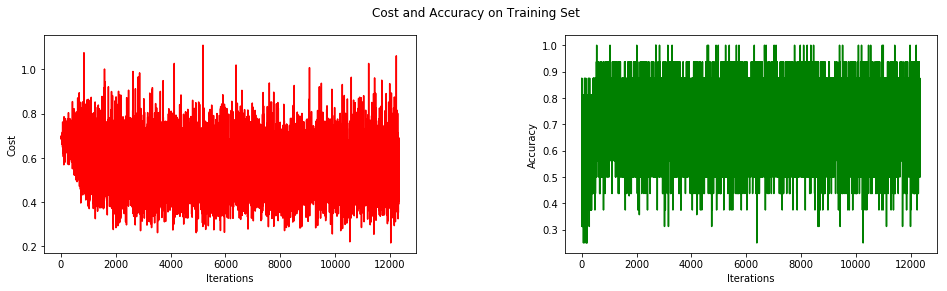

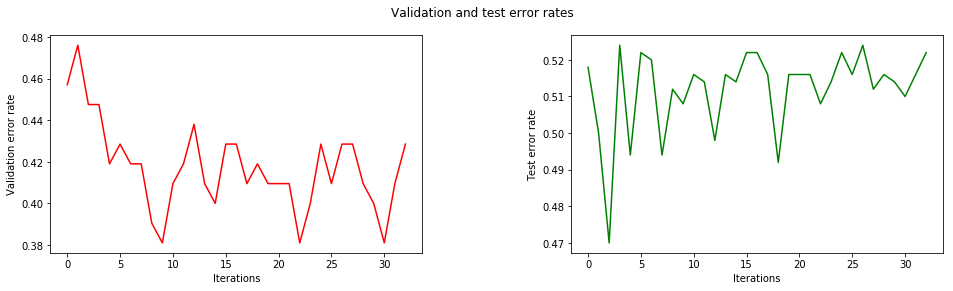

In [46]:
import matplotlib.pyplot as plt

fig_tr, ax_tr = plt.subplots(1, 2, figsize=(16, 4))
fig_tr.suptitle("Cost and Accuracy on Training Set")

ax_tr[0].plot(train_costs, '-r')
ax_tr[0].set_xlabel('Iterations')
ax_tr[0].set_ylabel('Cost')

ax_tr[1].plot(train_accus, '-g')
ax_tr[1].set_xlabel('Iterations')
ax_tr[1].set_ylabel('Accuracy')

fig_tr.subplots_adjust(wspace=.4)
plt.show()

fig_v, ax_v = plt.subplots(1, 2, figsize=(16, 4))
fig_v.suptitle("Validation and test error rates")

ax_v[0].plot(numpy.array(history_errs)[:,0], '-r')
ax_v[0].set_xlabel('Iterations')
ax_v[0].set_ylabel('Validation error rate')

ax_v[1].plot(numpy.array(history_errs)[:,1], '-g')
ax_v[1].set_xlabel('Iterations')
ax_v[1].set_ylabel('Test error rate')

fig_v.subplots_adjust(wspace=.4)
plt.show()
fig_v.savefig('errs.png')